**Importing Requisites**

In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

``**LOADING DATA**``

Normalize a tensor image with mean and standard deviation.
Given mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)`` for ``n`` channels, this transform
will normalize each channel of the input ``torch.*Tensor`` i.e.
``input[channel] = (input[channel] - mean[channel]) / std[channel]``

In [3]:
transform  = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.FashionMNIST(root='./fashionMNIST/', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.FashionMNIST(root='./fashionMNIST/', train=False,
                                       download=True, transform=transform)

In [4]:
print('The Length of Train set is : {} and of Test set is {}'.format(len(trainset), len(testset)))

The Length of Train set is : 60000 and of Test set is 10000


In [5]:
batch_size = 100
n_iters = 5500
num_epochs = n_iters / (len(trainset) / batch_size)
num_epochs = int(num_epochs)

learning_rate = 0.001

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size=batch_size,            
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Making Dictionary assigining label name to labels

In [7]:
classes = {0 : 'T-Shirt/Top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress',
           4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag',
           9 : 'Ankle boot'}

** Lets Plot some of the data **

In [8]:
def imshow(image, label):
    plt.title(classes[label])
    plt.imshow(image.reshape(28, 28), cmap = 'Greys', interpolation = 'nearest')

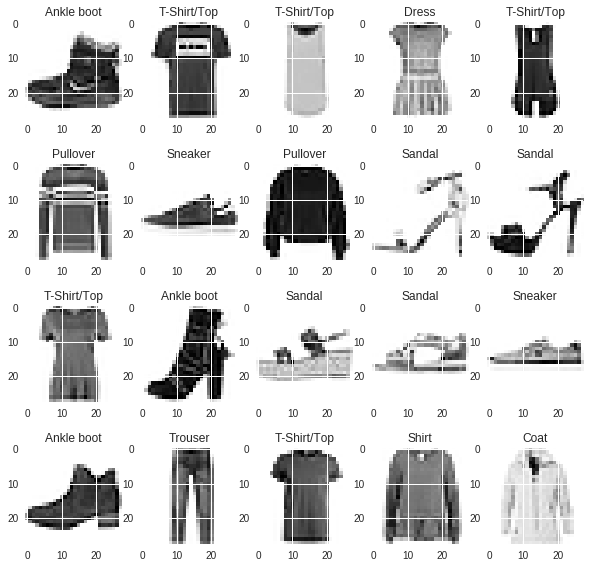

In [9]:
fig = plt.figure(figsize=(10,10))
column = 5
row = 4

for num in range(0, 20):
    image, label = trainset.train_data[num], trainset.train_labels[num].item()
    num += 1
    fig.add_subplot(row, column, num)
    imshow(image, label)

In [10]:
class convnet1(nn.Module):
    def __init__(self):
        super(convnet1, self).__init__()
        
        # Constraints for layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride = 1, padding=2)
        self.batch1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2) #default stride is equivalent to the kernel_size
        
        # Constraints for layer 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride = 1, padding=2)
        self.batch2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # Defining the Linear layer
        self.fc = nn.Linear(32*7*7, 10)
    
    # defining the network flow
    def forward(self, x):
        # Conv 1
        out = self.conv1(x)
        out = self.batch1(out)
        out = self.relu1(out)
        
        # Max Pool 1
        out = self.pool1(out)
        
        # Conv 2
        out = self.conv2(out)
        out = self.batch2(out)
        out = self.relu2(out)
        
        # Max Pool 2
        out = self.pool2(out)
        
        out = out.view(out.size(0), -1)
        # Linear Layer
        out = self.fc(out)
        
        return out

In [11]:
model = convnet1()

In [12]:
model.parameters

<bound method Module.parameters of convnet1(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)>

**Defining ``Loss Function`` and ``Optimizer``**

In [13]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

**Start training model**

In [14]:
losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader, 0):
        images = Variable(images.float())
        labels = Variable(labels)
        
        # Forward + Backward + Optimizer
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data[0])
        
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1,\
                     len(trainset)//batch_size, loss.data[0]))

Epoch : 1/9, Iter : 100/600,  Loss: 0.5071
Epoch : 1/9, Iter : 200/600,  Loss: 0.3655
Epoch : 1/9, Iter : 300/600,  Loss: 0.2287
Epoch : 1/9, Iter : 400/600,  Loss: 0.2877
Epoch : 1/9, Iter : 500/600,  Loss: 0.4005
Epoch : 1/9, Iter : 600/600,  Loss: 0.4008
Epoch : 2/9, Iter : 100/600,  Loss: 0.2327
Epoch : 2/9, Iter : 200/600,  Loss: 0.3752
Epoch : 2/9, Iter : 300/600,  Loss: 0.4940
Epoch : 2/9, Iter : 400/600,  Loss: 0.1683
Epoch : 2/9, Iter : 500/600,  Loss: 0.2138
Epoch : 2/9, Iter : 600/600,  Loss: 0.3039
Epoch : 3/9, Iter : 100/600,  Loss: 0.2026
Epoch : 3/9, Iter : 200/600,  Loss: 0.2484
Epoch : 3/9, Iter : 300/600,  Loss: 0.3350
Epoch : 3/9, Iter : 400/600,  Loss: 0.2764
Epoch : 3/9, Iter : 500/600,  Loss: 0.1561
Epoch : 3/9, Iter : 600/600,  Loss: 0.4443
Epoch : 4/9, Iter : 100/600,  Loss: 0.2019
Epoch : 4/9, Iter : 200/600,  Loss: 0.1831
Epoch : 4/9, Iter : 300/600,  Loss: 0.2330
Epoch : 4/9, Iter : 400/600,  Loss: 0.2141
Epoch : 4/9, Iter : 500/600,  Loss: 0.2710
Epoch : 4/9

**Saving the model**

In [15]:
torch.save(model.state_dict(), 'convnet1.pt')

**For loading the model**

In [16]:
conv1 = convnet1()
conv1.load_state_dict(torch.load('convnet1.pt'))

**`Evaluating` the model**

In [17]:

correct = 0
total = 0

for images, labels in test_loader:
  images = Variable(images.float())
  
  output = conv1(images)
  _, predicted = torch.max(output.data, 1)
  
  total += labels.size(0)
  correct += (predicted == labels).sum()

  
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on the 10000 test images: 90.0000 %
